# Train the ISIC 2024 Data
* Idea is to show how this works 
* This notebook will predicts on test using an average of all folds

In [2]:
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import binarize
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import GroupKFold
import h5py
import io
from PIL import Image
import torch.nn as nn
from torch.utils.data import DataLoader
import timm
from tqdm import tqdm

/home/bortiz4/.virtualenvs/cs379479group7/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

In [4]:
# Set up device and random seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
#number of epochs to train for
num_epochs = 50

#train entire model vs. just the classifier
freeze_base_model = False  #didn't get good results

# if this is set to true - full model is only generated as part of scoring (quick_train_record_count used)
# this saves GPU quota - but saved model won't reflect what was scored...
full_train_only_when_scoring = False  #must be False to save full model!
quick_train_record_count = 50000   #need to get at least some positive cases even for test run

Using device: cuda
GPU: NVIDIA L40S
Number of GPUs: 4


In [5]:
df_train = pd.read_csv("/data/bortiz4/isic-2024-challenge/train-metadata.csv")

num_folds = 5

gkf = GroupKFold(n_splits=num_folds)

df_train["fold"] = -1
for idx, (train_idx, val_idx) in enumerate(gkf.split(df_train, df_train["target"], groups=df_train["patient_id"])):
    df_train.loc[val_idx, "fold"] = idx

# Add summary
fold_summary = df_train.groupby("fold")["patient_id"].nunique().to_dict()
total_patients = df_train["patient_id"].nunique()

print(f"Fold Summary (patients per fold):")
for fold, count in fold_summary.items():
    if fold != -1:  # Exclude the initialization value
        print(f"Fold {fold}: {count} patients")
print(f"Total patients: {total_patients}")

/tmp/ipykernel_227302/3020479452.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("/data/bortiz4/isic-2024-challenge/train-metadata.csv")


Fold Summary (patients per fold):
Fold 0: 206 patients
Fold 1: 209 patients
Fold 2: 208 patients
Fold 3: 209 patients
Fold 4: 210 patients
Total patients: 1042


# Load meta data / review

In [6]:
# Set the HDF5 file path
TRAIN_HDF5_FILE_PATH = '/data/bortiz4/isic-2024-challenge/train-image.hdf5'

# are we scoring?
scoring = False
#check length of test data to see if we are scoring....
test_length = len(pd.read_csv("/data/bortiz4/isic-2024-challenge/test-metadata.csv"))
if test_length > 3:
    scoring = True

if not scoring:
    if full_train_only_when_scoring:
        df_train = df_train.head(quick_train_record_count)
                
print("\nOriginal Dataset Summary:")
print(f"Total number of samples: {len(df_train)}")
print(f"Number of unique patients: {df_train['patient_id'].nunique()}")

original_positive_cases = df_train['target'].sum()
original_total_cases = len(df_train)
original_positive_ratio = original_positive_cases / original_total_cases

print(f"Number of positive cases: {original_positive_cases}")
print(f"Number of negative cases: {original_total_cases - original_positive_cases}")
print(f"Ratio of negative to positive cases: {(original_total_cases - original_positive_cases) / original_positive_cases:.2f}:1")


Original Dataset Summary:
Total number of samples: 401059
Number of unique patients: 1042
Number of positive cases: 393
Number of negative cases: 400666
Ratio of negative to positive cases: 1019.51:1


# Downsample Negatives / Keep All Positives
* Keeping just 1% of negatives!
* We only use a small subset of the data in each fold for training...

In [7]:
#keep all positives
df_target_1 = df_train[df_train['target'] == 1]

#just use 1% of negatives
df_target_0 = df_train[df_train['target'] == 0].sample(frac=0.01, random_state=42)

df_train_balanced = pd.concat([df_target_1, df_target_0]).reset_index(drop=True)

# Print balanced dataset summary
print("Balanced Dataset Summary:")
print(f"Total number of samples: {len(df_train)}")
print(f"Number of unique patients: {df_train['patient_id'].nunique()}")

positive_cases = df_train_balanced['target'].sum()
total_cases = len(df_train_balanced)
positive_ratio = positive_cases / total_cases

print(f"Number of positive cases: {positive_cases}")
print(f"Number of negative cases: {total_cases - positive_cases}")
print(f"New ratio of negative to positive cases: {(total_cases - positive_cases) / positive_cases:.2f}:1")

Balanced Dataset Summary:
Total number of samples: 401059
Number of unique patients: 1042
Number of positive cases: 393
Number of negative cases: 4007
New ratio of negative to positive cases: 10.20:1


# ImageNet Setup for Training

In [8]:
def setup_model(num_classes=2, freeze_base_model=freeze_base_model):
    model = timm.create_model('tf_efficientnetv2_b1', 
                            checkpoint_path='/data/bortiz4/tf_efficientnetv2_b1-be6e41b0.pth',
                            pretrained=False)

    if freeze_base_model:
        for param in model.parameters():
            param.requires_grad = False

    model.classifier = nn.Linear(model.classifier.in_features, out_features=num_classes)
    return model.to(device)    

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for name, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

# Data Loading / Image Augmentation

In [9]:
class ISICDataset(Dataset):
    def __init__(self, hdf5_file, isic_ids, targets=None, transform=None):
        self.hdf5_file = hdf5_file
        self.isic_ids = isic_ids
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.isic_ids)

    def __getitem__(self, idx):
        with h5py.File(self.hdf5_file, 'r') as f:
            img_bytes = f[self.isic_ids[idx]][()]
        
        img = Image.open(io.BytesIO(img_bytes))
        img = np.array(img)  # Convert PIL Image to numpy array
        
        if self.transform:
            transformed = self.transform(image=img)
            img = transformed['image']
        
        if self.targets is not None:
            target = self.targets[idx]
        else:
            target = torch.tensor(-1)  # Dummy target for test set
            
        return img, target
    
# Prepare augmentation
aug_transform = A.Compose([
    A.RandomRotate90(),
    A.Flip(),
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.1, p=0.5),
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

base_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

/tmp/ipykernel_227302/2734219048.py:32: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(),


# Visualize image augmentation

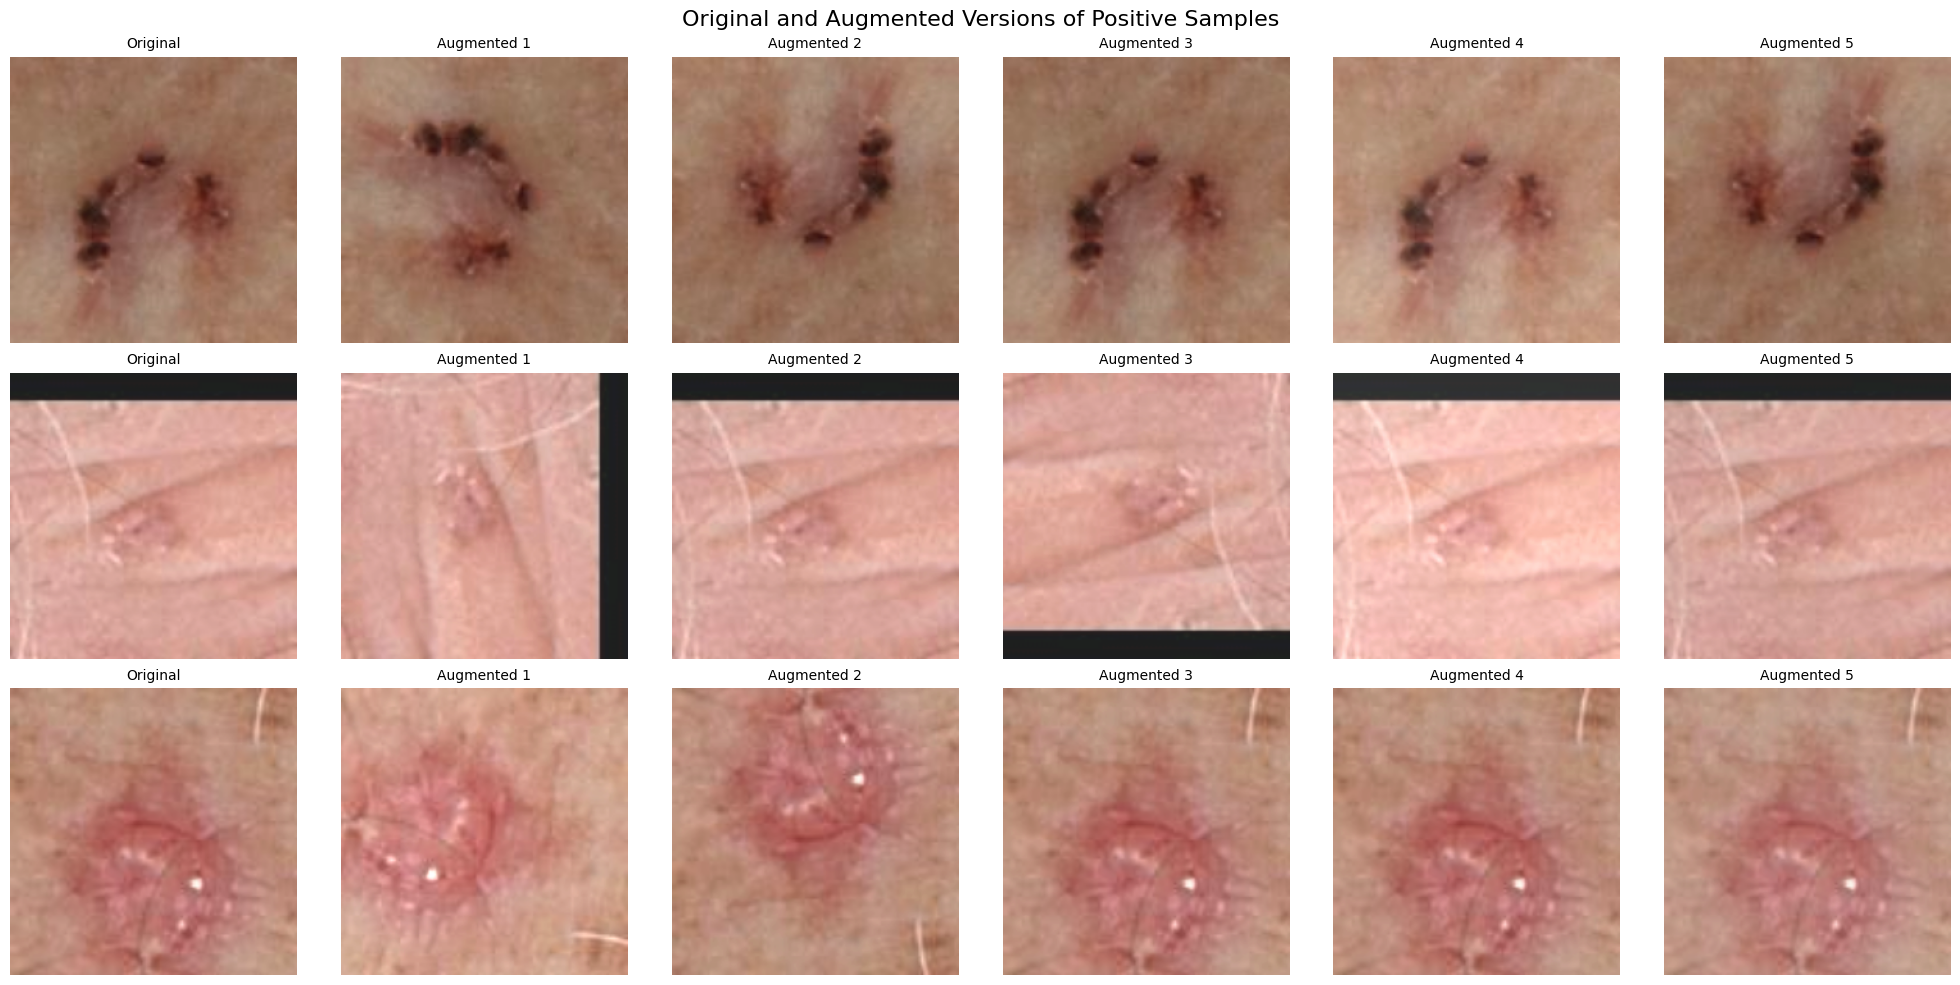

In [10]:
import matplotlib.pyplot as plt


def visualize_augmentations_positive(dataset, num_samples=3, num_augmentations=5, figsize=(20, 10)):
    # Find positive samples
    positive_samples = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        if label == 1:  # Assuming 1 is the positive class
            positive_samples.append(i)

        if len(positive_samples) == num_samples:
            break
    
    if len(positive_samples) < num_samples:
        print(f"Warning: Only found {len(positive_samples)} positive samples.")
    
    fig, axes = plt.subplots(num_samples, num_augmentations + 1, figsize=figsize)
    fig.suptitle("Original and Augmented Versions of Positive Samples", fontsize=16)

    for sample_num, sample_idx in enumerate(positive_samples):
        # Get a single sample
        original_image, label = dataset[sample_idx]
        
        # If the image is already a tensor (due to ToTensorV2 in the transform), convert it back to numpy
        if isinstance(original_image, torch.Tensor):
            original_image = original_image.permute(1, 2, 0).numpy()
            
        # Reverse the normalization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        original_image = (original_image * std + mean) * 255
        original_image = original_image.astype(np.uint8)

        # Display original image
        axes[sample_num, 0].imshow(original_image)
        axes[sample_num, 0].axis('off')
        axes[sample_num, 0].set_title("Original", fontsize=10)

        # Apply and display augmentations
        for aug_num in range(num_augmentations):
            augmented = dataset.transform(image=original_image)['image']
            # If the result is a tensor, convert it back to numpy
            if isinstance(augmented, torch.Tensor):
                augmented = augmented.permute(1, 2, 0).numpy()
            # Reverse the normalization
            augmented = (augmented * std + mean) * 255
            augmented = augmented.astype(np.uint8)
            
            axes[sample_num, aug_num + 1].imshow(augmented)
            axes[sample_num, aug_num + 1].axis('off')
            axes[sample_num, aug_num + 1].set_title(f"Augmented {aug_num + 1}", fontsize=10)

    plt.tight_layout()
    plt.show()
    
augtest_dataset = ISICDataset(
    hdf5_file=TRAIN_HDF5_FILE_PATH,
    isic_ids=df_train['isic_id'].values,
    targets=df_train['target'].values,
    transform=aug_transform,
)

visualize_augmentations_positive(augtest_dataset)

# Scoring code from https://www.kaggle.com/code/metric/isic-pauc-abovetpr

In [11]:
def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80) -> float:

    del solution[row_id_column_name]
    del submission[row_id_column_name]

    # rescale the target. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_gt = abs(np.asarray(solution.values)-1)
    
    # flip the submissions to their compliments
    v_pred = -1.0*np.asarray(submission.values)

    max_fpr = abs(1-min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

    return(partial_auc)

# Train / CV

In [12]:
import torch
import pandas as pd
from torch.cuda.amp import autocast, GradScaler
import numpy as np

def train_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, fold, epoch, device):
    scaler = GradScaler()
    
    # Training phase
    model.train()
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}, Fold {fold+1} Training"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad(set_to_none=True)
        
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
    # Evaluation phase
    model.eval()
    val_targets, val_outputs = [], []
    with torch.no_grad(), autocast():
        for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}, Fold {fold+1} Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_targets.append(targets.cpu())
            val_outputs.append(outputs.softmax(dim=1)[:, 1].cpu())
    
    scheduler.step()
    return torch.cat(val_targets).numpy(), torch.cat(val_outputs).numpy()


def cross_validation_train(df_train, num_folds, num_epochs, hdf5_file_path, aug_transform, base_transform, device):
    criterion = nn.CrossEntropyLoss()
    all_val_targets, all_val_outputs = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        epoch_val_targets, epoch_val_outputs = [], []

        for fold in range(num_folds):
            print(f"\nFold {fold + 1}/{num_folds}")
            
            # Split data for current fold
            train_df = df_train[df_train['fold'] != fold]
            val_df = df_train[df_train['fold'] == fold]
            
            # Create datasets and data loaders
            train_dataset = ISICDataset(hdf5_file_path, train_df['isic_id'].values, train_df['target'].values, aug_transform)
            val_dataset = ISICDataset(hdf5_file_path, val_df['isic_id'].values, val_df['target'].values, base_transform)
            
            train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
            val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)
            
            # Initialize model, optimizer, and scheduler
            model = setup_model().to(device)
            model = nn.DataParallel(model)
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.002)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
            
            print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, "
                  f"Train Pos Ratio: {train_df['target'].mean():.2%}, Val Pos Ratio: {val_df['target'].mean():.2%}")
            
            # Train and evaluate
            val_targets, val_outputs = train_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, fold, epoch, device)
            epoch_val_targets.extend(val_targets)
            epoch_val_outputs.extend(val_outputs)
            
            torch.save(model.state_dict(), f'model_fold_{fold}_epoch_{epoch + 1}.pth')
            
            # Create DataFrames with row_id for scoring
            solution_df = pd.DataFrame({'target': val_targets, 'row_id': range(len(val_targets))})
            submission_df = pd.DataFrame({'prediction': val_outputs, 'row_id': range(len(val_outputs))})
            fold_score = score(solution_df, submission_df, 'row_id')
            print(f'Fold {fold + 1} pAUC Score: {fold_score:.4f}')
        
        all_val_targets.extend(epoch_val_targets)
        all_val_outputs.extend(epoch_val_outputs)
        
        # Create DataFrames with row_id for scoring
        solution_df = pd.DataFrame({'target': epoch_val_targets, 'row_id': range(len(epoch_val_targets))})
        submission_df = pd.DataFrame({'prediction': epoch_val_outputs, 'row_id': range(len(epoch_val_outputs))})
        cv_score = score(solution_df, submission_df, 'row_id')
        print(f'Epoch {epoch + 1}/{num_epochs} CV pAUC Score: {cv_score:.4f}')

    return np.array(all_val_targets), np.array(all_val_outputs)

# Set up CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Perform cross-validation training
all_val_targets, all_val_outputs = cross_validation_train(df_train_balanced, num_folds, num_epochs, TRAIN_HDF5_FILE_PATH, aug_transform, base_transform, device)

Using device: cuda

Epoch 1/50

Fold 1/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1075

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1063

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1038

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.1051

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.1084
Epoch 1/50 CV pAUC Score: 0.0892

Epoch 2/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1357

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1182

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1269

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.1028

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0921
Epoch 2/50 CV pAUC Score: 0.0994

Epoch 3/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 3, Fold 1 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]

Fold 1 pAUC Score: 0.1294

Fold 2/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1004

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.0976

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0989

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.1089
Epoch 3/50 CV pAUC Score: 0.0978

Epoch 4/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.0985

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1107

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1236

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.1028

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.1213
Epoch 4/50 CV pAUC Score: 0.0924

Epoch 5/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1018

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.0833

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.0998

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0936

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0906
Epoch 5/50 CV pAUC Score: 0.0721

Epoch 6/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1224

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1204

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1351

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.1084

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0950
Epoch 6/50 CV pAUC Score: 0.0984

Epoch 7/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1233

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.0589

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1239

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0975

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 7, Fold 5 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

Fold 5 pAUC Score: 0.1085
Epoch 7/50 CV pAUC Score: 0.0987

Epoch 8/50

Fold 1/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1086

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.0814

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.0810

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0796

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.1305
Epoch 8/50 CV pAUC Score: 0.0762

Epoch 9/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 9, Fold 1 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

Fold 1 pAUC Score: 0.0700

Fold 2/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.0850

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1129

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.1056

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.1019
Epoch 9/50 CV pAUC Score: 0.0812

Epoch 10/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1123

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1307

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1072

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0694

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0965
Epoch 10/50 CV pAUC Score: 0.0941

Epoch 11/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.0970

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.0958

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.0765

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0547

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0803
Epoch 11/50 CV pAUC Score: 0.0626

Epoch 12/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 12, Fold 1 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

Fold 1 pAUC Score: 0.1188

Fold 2/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1071

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.0876

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0781

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0794
Epoch 12/50 CV pAUC Score: 0.0881

Epoch 13/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.0993

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1068

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 13, Fold 3 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]

Fold 3 pAUC Score: 0.1310

Fold 4/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0978

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0917
Epoch 13/50 CV pAUC Score: 0.0817

Epoch 14/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.0782

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1236

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1156

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 14, Fold 4 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

Fold 4 pAUC Score: 0.1002

Fold 5/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0985
Epoch 14/50 CV pAUC Score: 0.0943

Epoch 15/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1087

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1102

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1123

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0577

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0661
Epoch 15/50 CV pAUC Score: 0.0752

Epoch 16/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.0898

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1135

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.0534

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0582

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.1111
Epoch 16/50 CV pAUC Score: 0.0727

Epoch 17/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1091

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.0755

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1051

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 17, Fold 4 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

Fold 4 pAUC Score: 0.0934

Fold 5/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0941
Epoch 17/50 CV pAUC Score: 0.0491

Epoch 18/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1386

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1220

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1058

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.1025

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.1108
Epoch 18/50 CV pAUC Score: 0.0975

Epoch 19/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 19, Fold 1 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

Fold 1 pAUC Score: 0.0747

Fold 2/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1165

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1044

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0765

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.1068
Epoch 19/50 CV pAUC Score: 0.0917

Epoch 20/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1235

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 20, Fold 2 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]

Fold 2 pAUC Score: 0.1226

Fold 3/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1211

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.1093

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.1292
Epoch 20/50 CV pAUC Score: 0.0971

Epoch 21/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1436

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.0835

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.0746

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.1140

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0613
Epoch 21/50 CV pAUC Score: 0.0729

Epoch 22/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.0913

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1063

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1228

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.1130

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.1157
Epoch 22/50 CV pAUC Score: 0.1033

Epoch 23/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1062

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 23, Fold 2 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

Fold 2 pAUC Score: 0.1084

Fold 3/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1125

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.1142

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.1146
Epoch 23/50 CV pAUC Score: 0.1027

Epoch 24/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1300

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1104

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1066

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 24, Fold 4 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

Fold 4 pAUC Score: 0.1161

Fold 5/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0477
Epoch 24/50 CV pAUC Score: 0.1020

Epoch 25/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.0787

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.0868

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1113

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0833

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 25, Fold 5 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.02it/s]

Fold 5 pAUC Score: 0.0825
Epoch 25/50 CV pAUC Score: 0.0765

Epoch 26/50

Fold 1/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1260

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.0939

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.0918

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0894

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.1193
Epoch 26/50 CV pAUC Score: 0.0799

Epoch 27/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1355

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1074

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.0627

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0888

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0916
Epoch 27/50 CV pAUC Score: 0.0745

Epoch 28/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.0935

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.0687

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1043

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.1008

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 28, Fold 5 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

Fold 5 pAUC Score: 0.1066
Epoch 28/50 CV pAUC Score: 0.0865

Epoch 29/50

Fold 1/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1077

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1250

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1209

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0594

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0963
Epoch 29/50 CV pAUC Score: 0.0808

Epoch 30/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1223

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 30, Fold 2 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]

Fold 2 pAUC Score: 0.1125

Fold 3/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1104

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.1013

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.1033
Epoch 30/50 CV pAUC Score: 0.0974

Epoch 31/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.0813

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.0817

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 31, Fold 3 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]

Fold 3 pAUC Score: 0.1137

Fold 4/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0910

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.1149
Epoch 31/50 CV pAUC Score: 0.0902

Epoch 32/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.0733

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1059

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1204

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.1033

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0664
Epoch 32/50 CV pAUC Score: 0.0580

Epoch 33/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.0745

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.0759

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1123

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0639

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0926
Epoch 33/50 CV pAUC Score: 0.0722

Epoch 34/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1071

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1052

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 34, Fold 3 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

Fold 3 pAUC Score: 0.1150

Fold 4/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0872

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0923
Epoch 34/50 CV pAUC Score: 0.0807

Epoch 35/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1318

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1252

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1294

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.1025

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 35, Fold 5 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]

Fold 5 pAUC Score: 0.0623
Epoch 35/50 CV pAUC Score: 0.0901

Epoch 36/50

Fold 1/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.0903

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.0936

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1409

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.1020

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.1369
Epoch 36/50 CV pAUC Score: 0.1087

Epoch 37/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 37, Fold 1 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

Fold 1 pAUC Score: 0.0591

Fold 2/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1133

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1113

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0955

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0815
Epoch 37/50 CV pAUC Score: 0.0871

Epoch 38/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1225

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.0755

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.0426

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0545

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0936
Epoch 38/50 CV pAUC Score: 0.0501

Epoch 39/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1189

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.0795

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1376

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0761

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0575
Epoch 39/50 CV pAUC Score: 0.0799

Epoch 40/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 40, Fold 1 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.02it/s]

Fold 1 pAUC Score: 0.0826

Fold 2/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1145

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.0904

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.1024

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.1163
Epoch 40/50 CV pAUC Score: 0.0681

Epoch 41/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1093

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1217

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1024

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0793

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0853
Epoch 41/50 CV pAUC Score: 0.0859

Epoch 42/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1333

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.0888

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1017

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0963

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0720
Epoch 42/50 CV pAUC Score: 0.0808

Epoch 43/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 43, Fold 1 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]

Fold 1 pAUC Score: 0.1084

Fold 2/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1008

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.0905

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0940

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.1095
Epoch 43/50 CV pAUC Score: 0.0945

Epoch 44/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.0944

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 44, Fold 2 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]

Fold 2 pAUC Score: 0.0962

Fold 3/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1348

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.1016

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.1244
Epoch 44/50 CV pAUC Score: 0.0977

Epoch 45/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1086

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1019

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1048

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.1091

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0713
Epoch 45/50 CV pAUC Score: 0.0796

Epoch 46/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1297

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1256

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.0862

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.1078

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0835
Epoch 46/50 CV pAUC Score: 0.0989

Epoch 47/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1151

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 47, Fold 2 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

Fold 2 pAUC Score: 0.0851

Fold 3/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1049

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.1106

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0865
Epoch 47/50 CV pAUC Score: 0.0941

Epoch 48/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.1161

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1206

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.0509

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 48, Fold 4 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

Fold 4 pAUC Score: 0.0749

Fold 5/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 5 pAUC Score: 0.0424
Epoch 48/50 CV pAUC Score: 0.0630

Epoch 49/50

Fold 1/5
Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.0716

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1076

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.1292

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0988

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 49, Fold 5 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]

Fold 5 pAUC Score: 0.0652
Epoch 49/50 CV pAUC Score: 0.0871

Epoch 50/50

Fold 1/5


/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train: 3569, Val: 831, Train Pos Ratio: 8.77%, Val Pos Ratio: 9.63%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 1 pAUC Score: 0.0977

Fold 2/5
Train: 3530, Val: 870, Train Pos Ratio: 8.78%, Val Pos Ratio: 9.54%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 2 pAUC Score: 0.1041

Fold 3/5
Train: 3500, Val: 900, Train Pos Ratio: 9.00%, Val Pos Ratio: 8.67%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 3 pAUC Score: 0.0919

Fold 4/5
Train: 3515, Val: 885, Train Pos Ratio: 9.05%, Val Pos Ratio: 8.47%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

/tmp/ipykernel_227302/2820796577.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Fold 4 pAUC Score: 0.0895

Fold 5/5
Train: 3486, Val: 914, Train Pos Ratio: 9.06%, Val Pos Ratio: 8.42%


/tmp/ipykernel_227302/2820796577.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():

/tmp/ipykernel_227302/2820796577.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():

poch 50, Fold 5 Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.98it/s]

Fold 5 pAUC Score: 0.0897
Epoch 50/50 CV pAUC Score: 0.0840


In [14]:
# Final overall evaluation
print("\nFinal Overall Evaluation:")

# Calculate the official pAUC score
solution_df = pd.DataFrame({'target': all_val_targets, 'row_id': range(len(all_val_targets))})
submission_df = pd.DataFrame({'prediction': all_val_outputs, 'row_id': range(len(all_val_outputs))})
official_score = score(solution_df, submission_df, 'row_id')
print(f'Overall pAUC Score: {official_score:.4f}')

# Generate and print classification report
binary_predictions = binarize(np.array(all_val_outputs).reshape(-1, 1), threshold=0.5).reshape(-1)
report = classification_report(all_val_targets, binary_predictions, target_names=['Class 0', 'Class 1'])
print("\nOverall Classification Report:")
print(report)

# Print specific metrics for Class 1
report_dict = classification_report(all_val_targets, binary_predictions, target_names=['Class 0', 'Class 1'], output_dict=True)
print(f"\nClass 1 Metrics:")
print(f"Precision: {report_dict['Class 1']['precision']:.4f}")
print(f"Recall: {report_dict['Class 1']['recall']:.4f}")
print(f"F1-score: {report_dict['Class 1']['f1-score']:.4f}")


Final Overall Evaluation:
Overall pAUC Score: 0.0807

Overall Classification Report:
              precision    recall  f1-score   support

     Class 0       0.93      0.98      0.95    200350
     Class 1       0.56      0.20      0.30     19650

    accuracy                           0.91    220000
   macro avg       0.74      0.59      0.63    220000
weighted avg       0.89      0.91      0.90    220000


Class 1 Metrics:
Precision: 0.5606
Recall: 0.2033
F1-score: 0.2983


# Inference Code


In [20]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
import h5py
import timm
from PIL import Image
import io
import albumentations as A
from albumentations.pytorch import ToTensorV2

epoch_for_preds = num_epochs
model_path = ""

class ISICDataset(Dataset):
    def __init__(self, hdf5_file, isic_ids, targets=None, transform=None):
        self.hdf5_file = h5py.File(hdf5_file, 'r')  # Keep file open
        self.isic_ids = isic_ids
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.isic_ids)

    def __getitem__(self, idx):
        img_bytes = self.hdf5_file[self.isic_ids[idx]][()]
        img = Image.open(io.BytesIO(img_bytes))
        img = np.array(img)

        if self.transform:
            transformed = self.transform(image=img)
            img = transformed['image']

        target = self.targets[idx] if self.targets is not None else torch.tensor(-1)
        return img, target

    def __del__(self):
        self.hdf5_file.close()  # Ensure file is closed when object is destroyed

# Define the albumentations transformation
base_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

def setup_model(num_classes=2):
    return timm.create_model('tf_efficientnetv2_b1', pretrained=False, num_classes=num_classes)

def load_models(folds, device):
    models = []
    for fold in folds:
        model = setup_model().to(device).float()
        model.load_state_dict(torch.load(f'{model_path}model_fold_{fold}_epoch_{epoch_for_preds}.pth', map_location=device), strict=False)
        model.eval()
        models.append(model)
    model = nn.DataParallel(model)    
    return models

@torch.no_grad()  # Apply no_grad to the entire function
def ensemble_predict(models, test_loader, device):
    all_predictions = []
    for inputs, _ in tqdm(test_loader, desc="Predicting"):
        inputs = inputs.to(device)
        fold_predictions = torch.stack([model(inputs).softmax(dim=1)[:, 1] for model in models])
        avg_predictions = fold_predictions.mean(dim=0)
        all_predictions.extend(avg_predictions.cpu().numpy())
    return all_predictions


# Generate out-of-fold predictions for Train


In [23]:
def generate_oof_predictions(df_train, folds, hdf5_file_path, transform):
    oof_predictions = np.zeros(len(df_train))
    model_filenames = [''] * len(df_train)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    models = load_models(folds, device)

    for fold in folds:
        print(f"Generating predictions for fold {fold + 1}/{num_folds}")
        val_df = df_train[df_train['fold'] == fold].copy()
        val_dataset = ISICDataset(hdf5_file_path, val_df['isic_id'].values, val_df['target'].values, transform)
        val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)
        
        fold_predictions = ensemble_predict([models[fold]], val_loader, device)
        
        oof_predictions[val_df.index] = fold_predictions
        model_filename = f'model_fold_{fold}_epoch_1.pth'
        for idx in val_df.index:
            model_filenames[idx] = model_filename

    return oof_predictions, model_filenames


if not scoring:
    # Set up CUDA if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define the number of folds
    folds = [0, 1, 2, 3, 4]

    # Generate out-of-fold predictions
    oof_predictions, model_filenames = generate_oof_predictions(df_train, folds, TRAIN_HDF5_FILE_PATH, base_transform)

    # Create DataFrame for OOF predictions
    oof_df = pd.DataFrame({
        'isic_id': df_train['isic_id'],
        'target': df_train['target'],
        'fold': df_train['fold'],
        'oof_prediction': oof_predictions,
        'model_filename': model_filenames
    })

    # Save OOF predictions to CSV
    oof_df.to_csv('oof_predictions.csv', index=False)
    print("Out-of-fold predictions saved to oof_predictions.csv")
    print(oof_df.head())

Using device: cuda


/tmp/ipykernel_227302/3751592015.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{model_path}model_fold_{fold}_epoch_{epoch_for_preds

Generating predictions for fold 1/5



redicting: 100%|██████████| 157/157 [00:26<00:00,  5.87it/s]

Generating predictions for fold 2/5



redicting: 100%|██████████| 157/157 [00:25<00:00,  6.09it/s]

Generating predictions for fold 3/5



redicting: 100%|██████████| 157/157 [00:25<00:00,  6.06it/s]

Generating predictions for fold 4/5



redicting: 100%|██████████| 157/157 [00:25<00:00,  6.07it/s]

Generating predictions for fold 5/5



redicting: 100%|██████████| 157/157 [00:25<00:00,  6.10it/s]

Out-of-fold predictions saved to oof_predictions.csv
        isic_id  target  fold  oof_prediction            model_filename
0  ISIC_0015670       0     3        0.508869  model_fold_3_epoch_1.pth
1  ISIC_0015845       0     1        0.578416  model_fold_1_epoch_1.pth
2  ISIC_0015864       0     4        0.518770  model_fold_4_epoch_1.pth
3  ISIC_0015902       0     1        0.454475  model_fold_1_epoch_1.pth
4  ISIC_0024200       0     0        0.489323  model_fold_0_epoch_1.pth


# Predict for test

In [24]:
df_test = pd.read_csv("/data/bortiz4/isic-2024-challenge/test-metadata.csv")
TEST_HDF5_FILE_PATH = '/data/bortiz4/isic-2024-challenge/test-image.hdf5'

# Set up CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# folds to use for pred
folds = [0, 1, 2, 3, 4]

models = load_models(folds, device)

# Prepare your test dataset
test_dataset = ISICDataset(
    hdf5_file=TEST_HDF5_FILE_PATH,
    isic_ids=df_test['isic_id'].values,
    transform=base_transform,
)    

# Create test data loader
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)

# Run predictions
predictions = ensemble_predict(models, test_loader, device)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'isic_id': df_test['isic_id'],
    'target': predictions
})

# Save predictions to CSV
submission_df.to_csv('submission.csv', index=False)
print("Predictions saved to submission.csv")
print(submission_df.head())

Using device: cuda


/tmp/ipykernel_227302/3751592015.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{model_path}model_fold_{fold}_epoch_{epoch_for_preds

Predictions saved to submission.csv
        isic_id    target
0  ISIC_0015657  0.524378
1  ISIC_0015729  0.505049
2  ISIC_0015740  0.502453
